# **Importing Data & Dependencies**

In [31]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

import joblib
import warnings
warnings.filterwarnings('ignore')

In [62]:
from google.colab import drive
drive.mount('/content/drive')

users_df = pd.read_csv("/content/drive/My Drive/Users.csv")
ratings_df = pd.read_csv("/content/drive/My Drive/Ratings.csv")
books_df = pd.read_csv("/content/drive/My Drive/Books.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


# **Preprocessing Data**

In [64]:
# Merge datasets
merged_df = pd.merge(ratings_df, books_df, on='ISBN')
final_df = pd.merge(merged_df, users_df, on='User-ID')

# Select the features that we need
df_selected = final_df[["User-ID", "Book-Rating", "Book-Title", "Book-Author"]]

# Drop NA values
df_selected = df_selected[df_selected['Book-Rating'] != 0]

# Convert specific columns to integers and strings
df_selected['User-ID'] = df_selected['User-ID'].astype(int)
df_selected['Book-Rating'] = df_selected['Book-Rating'].astype(int)
df_selected['Book-Title'] = df_selected['Book-Title'].astype(str)
df_selected['Book-Author'] = df_selected['Book-Author'].astype(str)

# Define which columns are categorical and numerical
categorical_cols = ['Book-Title', 'Book-Author']
numerical_cols = ['User-ID']

# Preprocessor for categorical and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

df_selected.shape

(383842, 4)

In [33]:
df_selected.head()

,User-ID,Book-Rating,Book-Title,Book-Author
1,2313,5,Flesh Tones: A Novel,M. J. Rose
2,2313,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card
3,2313,8,In Cold Blood (Vintage International),TRUMAN CAPOTE
4,2313,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells
5,2313,5,The Mistress of Spices,Chitra Banerjee Divakaruni


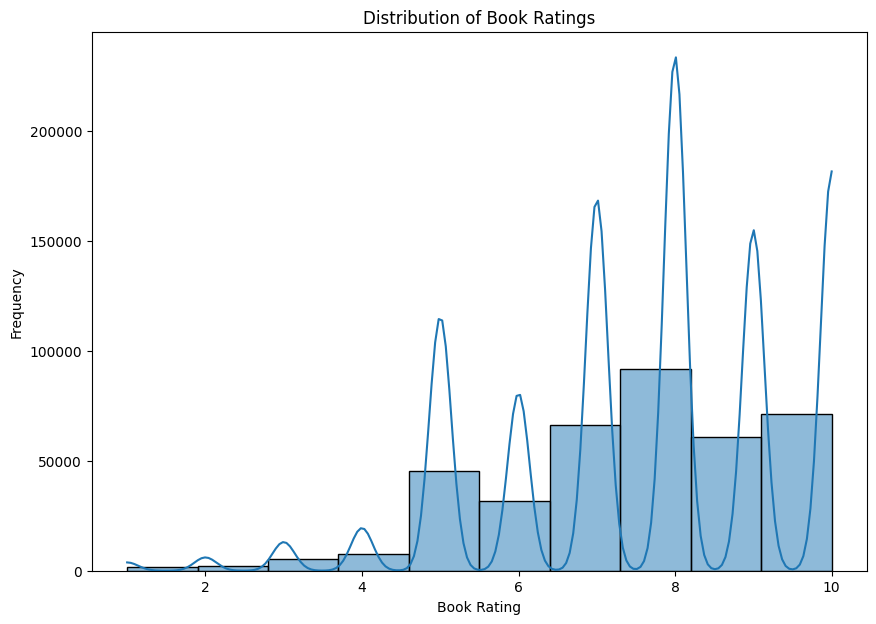

In [34]:
plt.figure(figsize=(10, 7))
sns.histplot(df_selected['Book-Rating'], bins=10, kde=True)
plt.title('Distribution of Book Ratings')
plt.xlabel('Book Rating')
plt.ylabel('Frequency')
plt.show()

Summary Statistics of Number of Ratings per User:
count    68091.000000
mean         5.637191
std         41.742511
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       6943.000000
Name: Book-Rating, dtype: float64


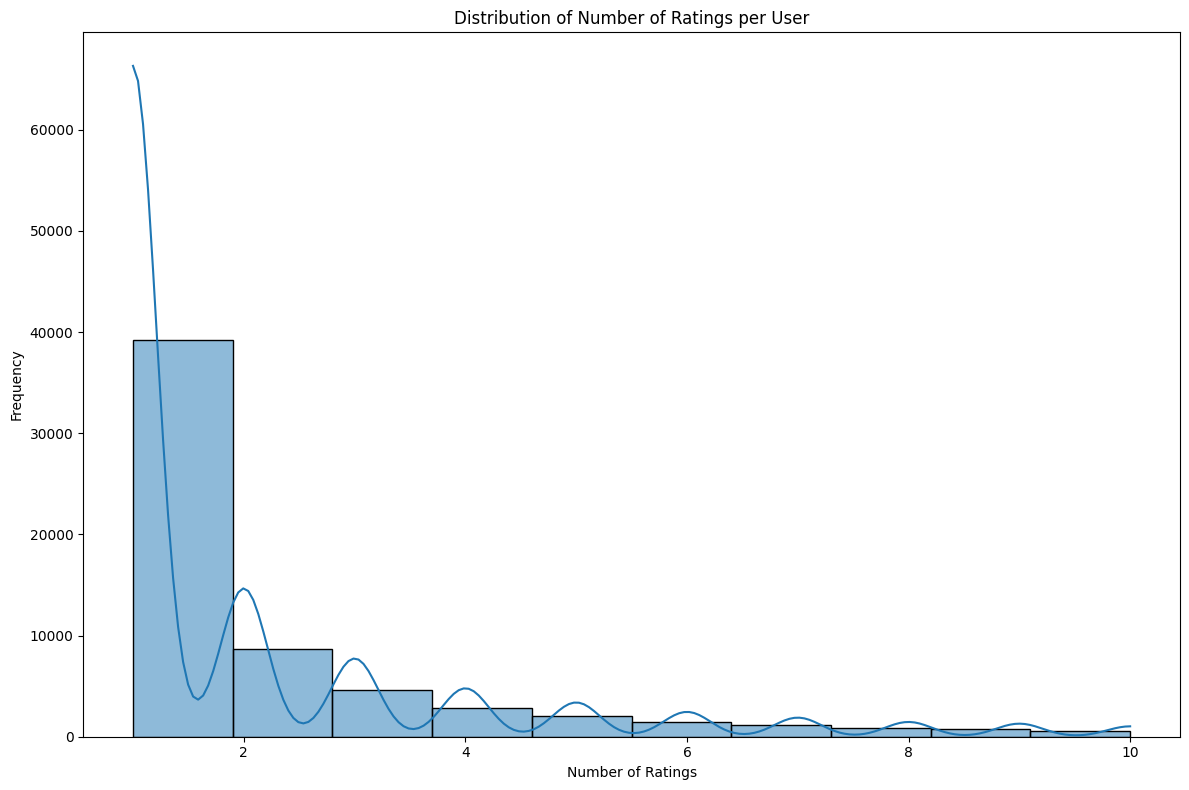

In [94]:
# Calculate number of ratings per user
ratings_per_user = df_selected.groupby('User-ID')['Book-Rating'].count()
# Optionally, print summary statistics
print("Summary Statistics of Number of Ratings per User:")
print(ratings_per_user.describe())


# Filter out extreme outliers (e.g., users with more than 100 ratings)
ratings_per_user = ratings_per_user[ratings_per_user <= 10]

# Plot histogram with adjusted bins and KDE
plt.figure(figsize=(12, 8))
sns.histplot(ratings_per_user, bins=10, kde=True)
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Summary Statistics of Number of Ratings per User:
count    135567.000000
mean          2.831382
std           9.135691
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         707.000000
Name: Book-Rating, dtype: float64


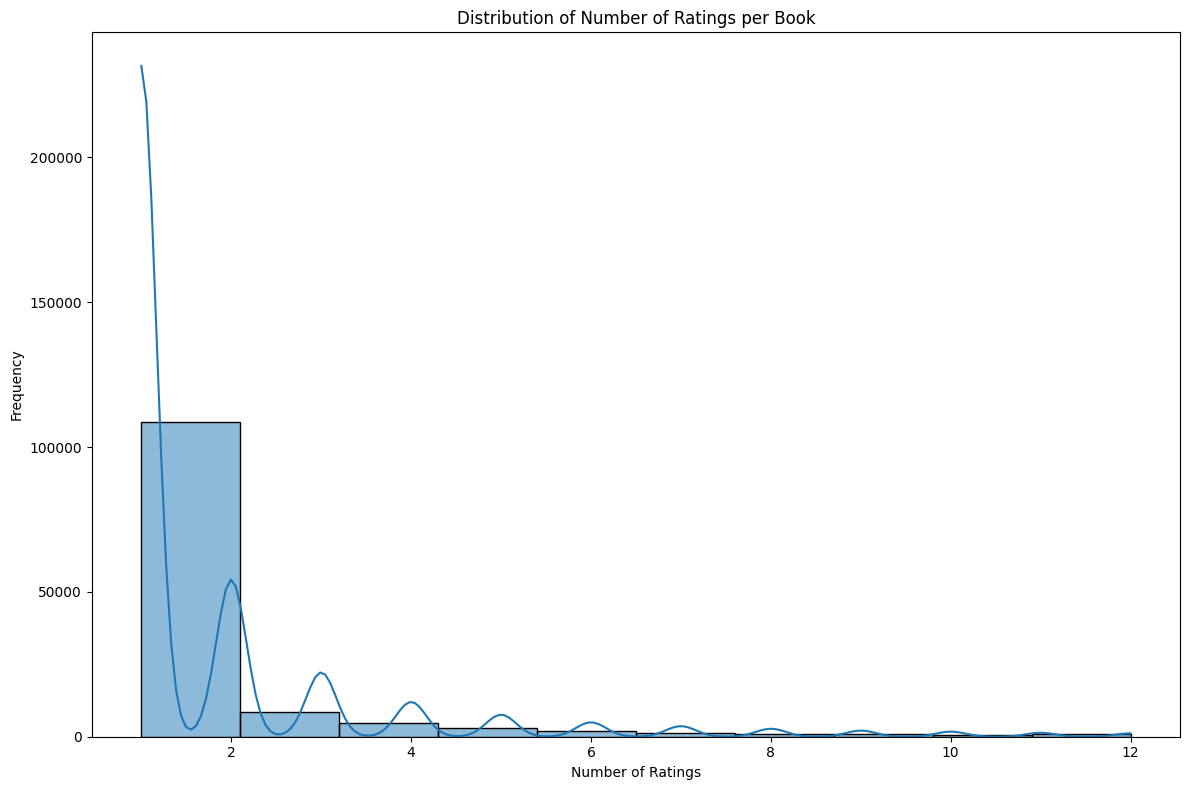

In [101]:

# Calculate number of ratings per book
ratings_per_book = df_selected.groupby('Book-Title')['Book-Rating'].count()
# Optionally, print summary statistics
print("Summary Statistics of Number of Ratings per User:")
print(ratings_per_book.describe())

# Filter out extreme outliers if necessary
ratings_per_book = ratings_per_book[ratings_per_book <= 12]  # Example: filter books with more than 100 ratings

# Plot histogram with adjusted bins and KDE
plt.figure(figsize=(12, 8))
sns.histplot(ratings_per_book, bins=10, kde=True)
plt.title('Distribution of Number of Ratings per Book')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

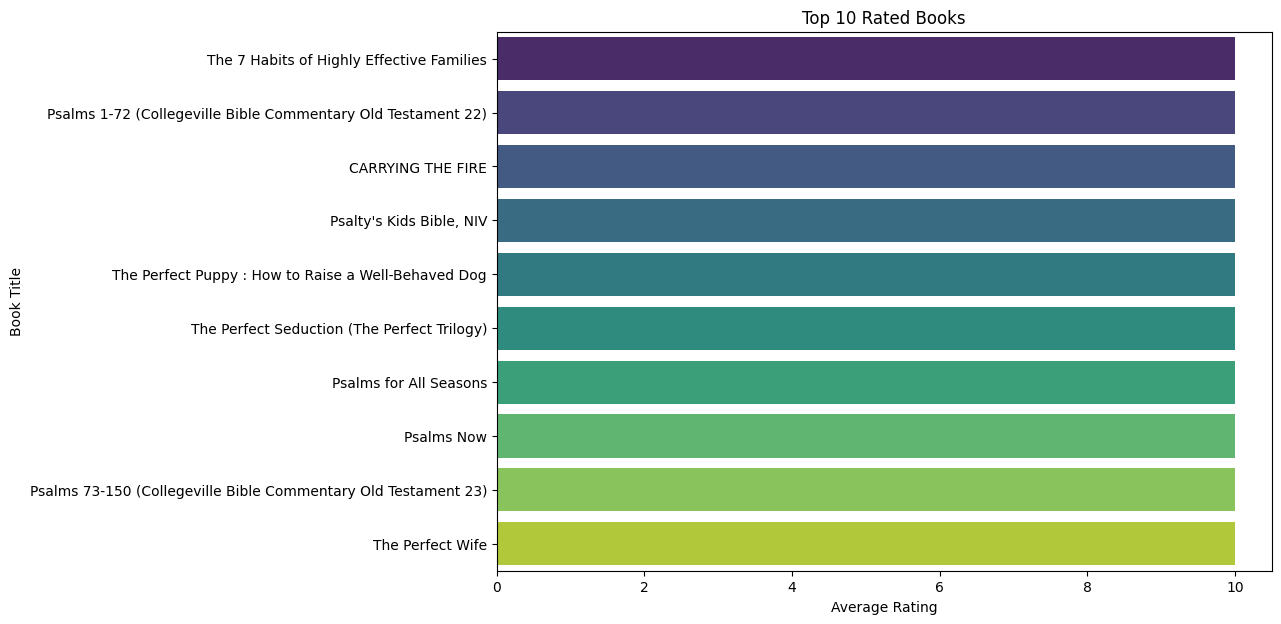

In [48]:
top_rated_books = df_selected.groupby('Book-Title')['Book-Rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 7))
sns.barplot(x=top_rated_books, y=top_rated_books.index, palette='viridis' )
plt.title('Top 10 Rated Books')
plt.xlabel('Average Rating')
plt.ylabel('Book Title')
plt.show()
#This visualization effectively shows the top 10 rated books based on their average ratings, making it easy to identify which books have received the highest average ratings.

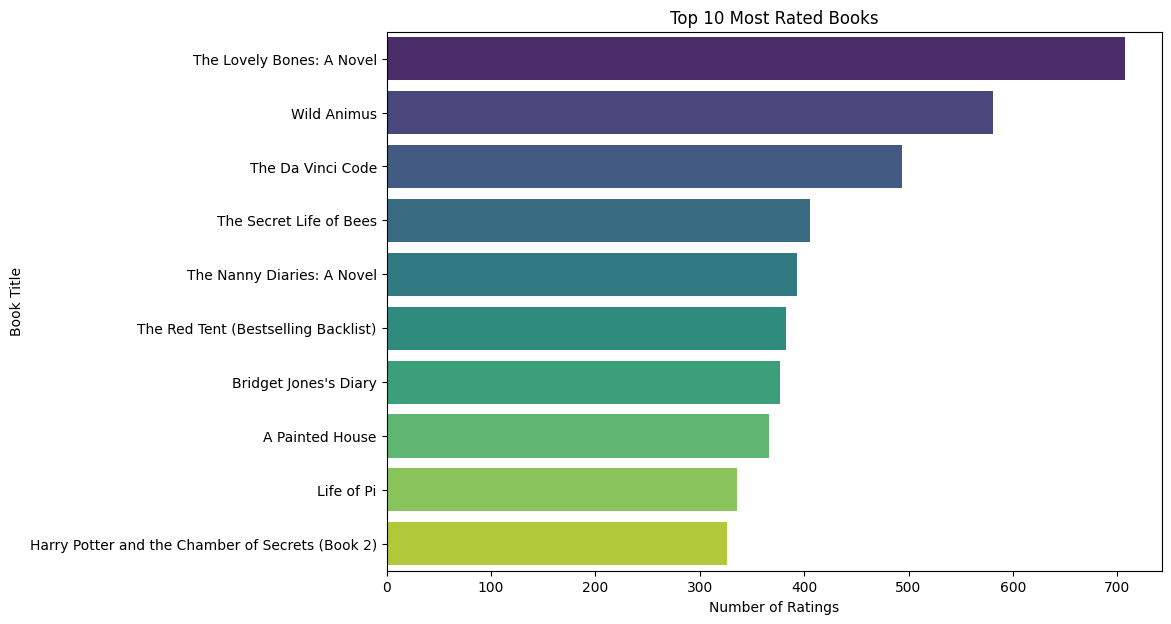

In [47]:
most_rated_books = df_selected.groupby('Book-Title')['Book-Rating'].count().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 7))
sns.barplot(x=most_rated_books.values, y=most_rated_books.index, palette='viridis')
plt.title('Top 10 Most Rated Books')
plt.xlabel('Number of Ratings')
plt.ylabel('Book Title')
plt.show()


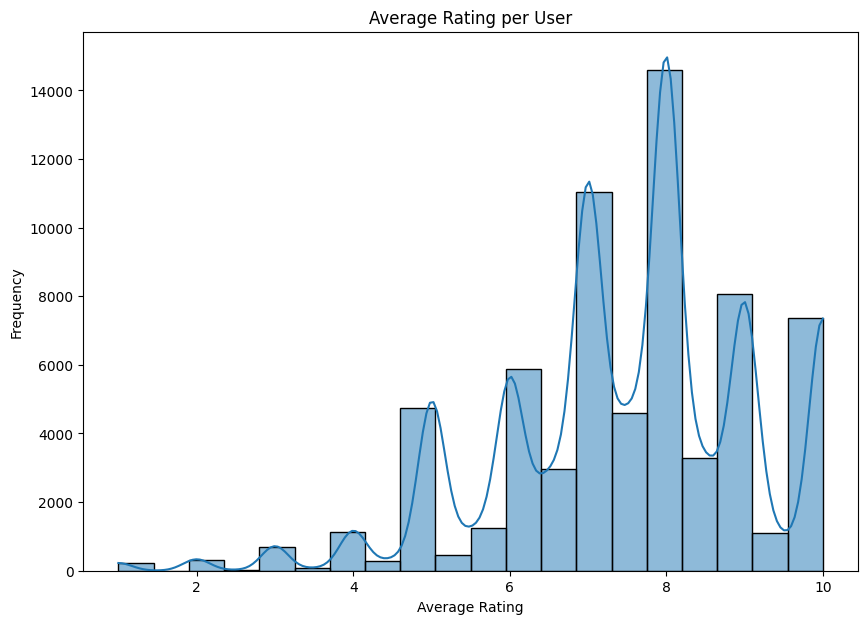

In [49]:
#Bias and Fairness Analysis: Analyze if the model shows any bias towards specific users or books.
user_avg_rating = df_selected.groupby('User-ID')['Book-Rating'].mean()
book_avg_rating = df_selected.groupby('Book-Title')['Book-Rating'].mean()

plt.figure(figsize=(10, 7))
sns.histplot(user_avg_rating, bins=20, kde=True)
plt.title('Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()


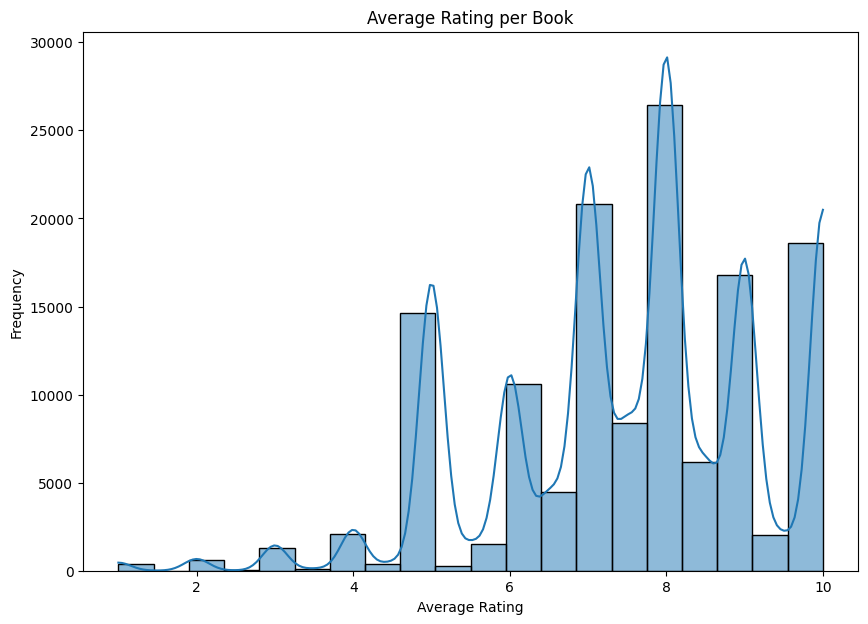

In [50]:
plt.figure(figsize=(10, 7))
sns.histplot(book_avg_rating, bins=20, kde=True)
plt.title('Average Rating per Book')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()
#These plots will visually represent the distribution of average ratings across users and books. By examining these distributions,
#you can start to identify potential biases in the dataset, such as certain users consistently giving higher or lower ratings, or certain books receiving consistently higher or lower ratings.
#This analysis can provide insights into whether the model might inadvertently learn biases from the data during training.

In [44]:
#Hyperparameter Tuning: Use grid search or random search to optimize hyperparameters of the neural network.
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

def create_model(learning_rate=0.01, units=64):
    model = Model(inputs=[user_input, book_input, additional_features_input], outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_squared_error'])
    return model

model = KerasRegressor(build_fn=create_model, epochs=20, batch_size=64, verbose=0)
param_grid = {'learning_rate': [0.01, 0.001], 'units': [64, 128]}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit([user_ids_train, book_ids_train, X_train_selected], y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


ModuleNotFoundError: No module named 'keras.wrappers'

In [43]:
#Feature Importance Analysis: Analyze which features are most important in predicting book ratings.
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test_selected, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(range(X_test_selected.shape[1]), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(X_test_selected.shape[1]), X_test.columns[sorted_idx])
plt.title('Feature Importance')
plt.show()


TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.src.engine.functional.Functional object at 0x7931c13de8c0> does not.

# **The Tensorflow Model**

This model is predicting Book-Rating

In [ ]:
# Split data into train and test sets
X = df_selected.drop(['Book-Rating'], axis=1)
y = df_selected['Book-Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform preprocessing on training data, and transform on test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Save the fitted preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

# Apply VarianceThreshold to reduce dimensionality
selector = VarianceThreshold(threshold=0.1)
X_train_selected = selector.fit_transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

# Convert sparse matrix to dense array
X_train_selected = X_train_selected.toarray()
X_test_selected = X_test_selected.toarray()

# Mapping user and book IDs
user_id_mapping = {id: idx for idx, id in enumerate(df_selected['User-ID'].unique())}
book_id_mapping = {title: idx for idx, title in enumerate(df_selected['Book-Title'].unique())}

df_selected['user_idx'] = df_selected['User-ID'].map(user_id_mapping)
df_selected['book_idx'] = df_selected['Book-Title'].map(book_id_mapping)

# Split mapped data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_selected[['user_idx', 'book_idx']], df_selected['Book-Rating'], test_size=0.2, random_state=42)

# Collaborative filtering components
num_users = df_selected['user_idx'].nunique()
num_books = df_selected['book_idx'].nunique()

user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users, output_dim=32, name='user_embedding')(user_input)
user_vec = Flatten(name='user_flatten')(user_embedding)

book_input = Input(shape=(1,), name='book_input')
book_embedding = Embedding(input_dim=num_books, output_dim=32, name='book_embedding')(book_input)
book_vec = Flatten(name='book_flatten')(book_embedding)

# Additional features component
additional_features_input = Input(shape=(X_train_selected.shape[1],), name='additional_features_input')

# Concatenate collaborative and additional features inputs
concat = Concatenate()([user_vec, book_vec, additional_features_input])
dense1 = Dense(64, activation='relu')(concat)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

# Define and compile the model
model = Model(inputs=[user_input, book_input, additional_features_input], outputs=output)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01), metrics=['mean_squared_error'])

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Prepare inputs for training
user_ids_train = X_train['user_idx'].values
book_ids_train = X_train['book_idx'].values
user_ids_test = X_test['user_idx'].values
book_ids_test = X_test['book_idx'].values

# Fit the model with manual validation split
history = model.fit(
    [user_ids_train, book_ids_train, X_train_selected], y_train,
    validation_data=([user_ids_test, book_ids_test, X_test_selected], y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, mse = model.evaluate([user_ids_test, book_ids_test, X_test_selected], y_test)
print("Mean Squared Error:", mse)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
 101/4799 [..............................] - ETA: 6:15 - loss: 9.7748 - mean_squared_error: 9.7748

# **Evaluating The Model & Personalized Recommendation**


In [120]:
# Calculate average rating across all books
average_rating = df_selected['Book-Rating'].mean()
df = df_selected.copy()
df['AverageRating'] = average_rating

# Calculate MAE and MSE between original ratings and average ratings
mae_baseline = mean_absolute_error(df['Book-Rating'], df['AverageRating'])
mse_baseline = mean_squared_error(df['Book-Rating'], df['AverageRating'])

print(f"Baseline Mean Absolute Error (MAE): {mae_baseline}")
print(f"Baseline Mean Squared Error (MSE): {mse_baseline}")

# Training the model
model.fit([user_ids_train, book_ids_train, X_train_selected], y_train)

# Generate predictions on the test set
predictions = model.predict([user_ids_test, book_ids_test, X_test_selected])
predicted_ratings = predictions.flatten()

# Evaluate the model
mae_model = mean_absolute_error(y_test, predicted_ratings)
mse_model = mean_squared_error(y_test, predicted_ratings)

print(f"Model Mean Absolute Error (MAE): {mae_model}")
print(f"Model Mean Squared Error (MSE): {mse_model}")

Baseline Mean Absolute Error (MAE): 1.4942347405482383
Baseline Mean Squared Error (MSE): 3.3905218063767264
2154/2154 [==============================] - 4s 2ms/step
Model Mean Absolute Error (MAE): 1.2801121182743627
Model Mean Squared Error (MSE): 2.846796197169935


In [108]:
# Display recommendations
recommendations = pd.DataFrame({
    'User-ID': user_ids_sample,
    'Book-ID': book_ids_sample,
    'Actual Rating': actual_ratings_sample,
    'Predicted Rating': predicted_ratings_sample
})

# Print sample personalized recommendations
print("\nSample Personalized Recommendations:")
print(tabulate(recommendations, headers='keys', tablefmt='psql'))


Sample Personalized Recommendations:
+----+-----------+-----------+-----------------+--------------------+
|    |   User-ID |   Book-ID |   Actual Rating |   Predicted Rating |
|----+-----------+-----------+-----------------+--------------------|
|  0 |        52 |        88 |         4.32977 |            2.16858 |
|  1 |        93 |       373 |         1.84936 |            2.46545 |
|  2 |        15 |       100 |         1.7273  |            2.82428 |
|  3 |        72 |       872 |         1.73362 |            4.1407  |
|  4 |        61 |       664 |         2.21697 |            1.7987  |
|  5 |        21 |       131 |         3.09903 |            3.05694 |
|  6 |        83 |       662 |         2.72778 |            3.36966 |
|  7 |        87 |       309 |         2.16492 |            1.1858  |
|  8 |        75 |       770 |         3.44741 |            3.43018 |
|  9 |        75 |       344 |         1.55798 |            1.6821  |
+----+-----------+-----------+-----------------+----

2154/2154 [==============================] - 5s 2ms/step


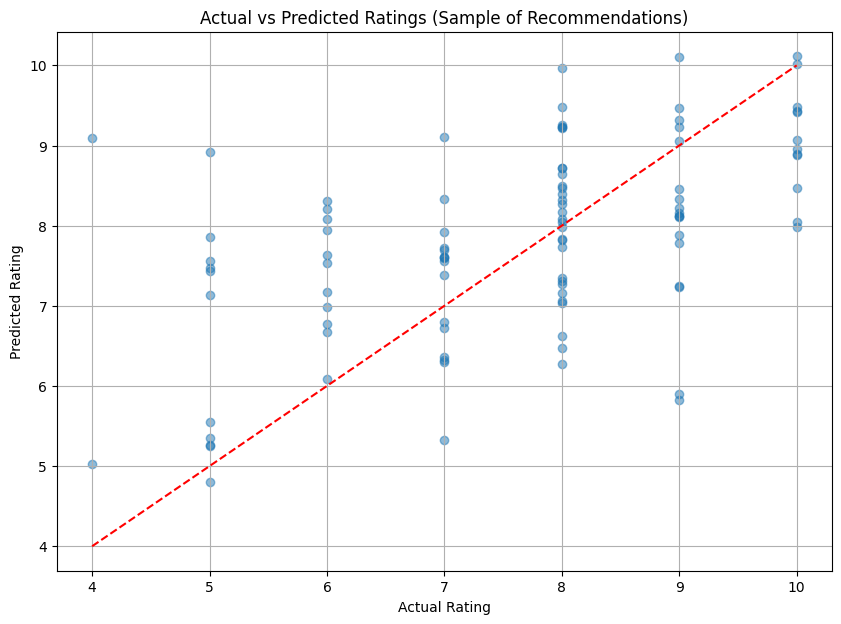

In [117]:
# Make predictions
predicted_ratings = model.predict([user_ids_test, book_ids_test, X_test_selected]).flatten()

# Create a DataFrame with predictions
predictions_df = pd.DataFrame({
    'User-ID': user_ids_test,
    'Book-ID': book_ids_test,
    'Actual Rating': y_test,
    'Predicted Rating': predicted_ratings
})
# Sample a subset of recommendations
num_samples = 100
random_indices = np.random.choice(len(predictions_df), num_samples, replace=False)
sample_recommendations = predictions_df.iloc[random_indices]

# Plotting the actual vs predicted ratings
plt.figure(figsize=(10, 7))
plt.scatter(sample_recommendations['Actual Rating'], sample_recommendations['Predicted Rating'], alpha=0.5)
plt.plot([min(sample_recommendations['Actual Rating']), max(sample_recommendations['Actual Rating'])],
         [min(sample_recommendations['Actual Rating']), max(sample_recommendations['Actual Rating'])],
         color='red', linestyle='--')
plt.title('Actual vs Predicted Ratings (Sample of Recommendations)')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.grid(True)
plt.show()

In [ ]:
# Assuming you have the actual and predicted ratings
actual_ratings = recommendations['Actual Rating']
predicted_ratings = recommendations['Predicted Rating']

# Calculate MAE and MSE for your model
mae_model = mean_absolute_error(actual_ratings, predicted_ratings)
mse_model = mean_squared_error(actual_ratings, predicted_ratings)

# Print model performance
print(f"Model Mean Absolute Error (MAE): {mae_model}")
print(f"Model Mean Squared Error (MSE): {mse_model}")

# Calculate percentage correctness improvement for MAE and MSE
mae_improvement = ((mae_baseline - mae_model) / mae_baseline) * 100
mse_improvement = ((mse_baseline - mse_model) / mse_baseline) * 100

print(f"MAE Improvement: {mae_improvement:.2f}%")
print(f"MSE Improvement: {mse_improvement:.2f}%")


# **Saving the Model**

In [ ]:
# Save the model
model.save('tf_model.h5')

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import joblib

# Assuming df_selected is already prepared as per your preprocessing steps

# Count number of ratings per user
user_ratings_count = df_selected.groupby('User-ID')['Book-Rating'].count()

# Filter users with more than one rating
active_users = user_ratings_count[user_ratings_count > 1].index

# Filter the dataset to keep only active users
df_selected = df_selected[df_selected['User-ID'].isin(active_users)]

# Split data into train and test sets
X = df_selected.drop(['Book-Rating'], axis=1)
y = df_selected['Book-Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical columns
categorical_cols = ['Book-Title', 'Book-Author']
numerical_cols = ['User-ID']

# Preprocessor for categorical and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

# Fit and transform preprocessing on training data, and transform on test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Save the fitted preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

# Apply VarianceThreshold to reduce dimensionality
selector = VarianceThreshold(threshold=0.1)
X_train_selected = selector.fit_transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

# Convert sparse matrix to dense array
X_train_selected = X_train_selected.toarray()
X_test_selected = X_test_selected.toarray()

# Mapping user and book IDs
user_id_mapping = {id: idx for idx, id in enumerate(df_selected['User-ID'].unique())}
book_id_mapping = {title: idx for idx, title in enumerate(df_selected['Book-Title'].unique())}

df_selected['user_idx'] = df_selected['User-ID'].map(user_id_mapping)
df_selected['book_idx'] = df_selected['Book-Title'].map(book_id_mapping)

# Split mapped data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_selected[['user_idx', 'book_idx']], df_selected['Book-Rating'], test_size=0.2, random_state=42)

# Collaborative filtering components
num_users = df_selected['user_idx'].nunique()
num_books = df_selected['book_idx'].nunique()

user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users, output_dim=32, name='user_embedding')(user_input)
user_vec = Flatten(name='user_flatten')(user_embedding)

book_input = Input(shape=(1,), name='book_input')
book_embedding = Embedding(input_dim=num_books, output_dim=32, name='book_embedding')(book_input)
book_vec = Flatten(name='book_flatten')(book_embedding)

# Additional features component
additional_features_input = Input(shape=(X_train_selected.shape[1],), name='additional_features_input')

# Concatenate collaborative and additional features inputs
concat = Concatenate()([user_vec, book_vec, additional_features_input])
dense1 = Dense(64, activation='relu')(concat)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

# Define and compile the model
model = Model(inputs=[user_input, book_input, additional_features_input], outputs=output)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01), metrics=['mean_squared_error'])

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Prepare inputs for training
user_ids_train = X_train['user_idx'].values
book_ids_train = X_train['book_idx'].values
user_ids_test = X_test['user_idx'].values
book_ids_test = X_test['book_idx'].values

# Fit the model with manual validation split
history = model.fit(
    [user_ids_train, book_ids_train, X_train_selected], y_train,
    validation_data=([user_ids_test, book_ids_test, X_test_selected], y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, mse = model.evaluate([user_ids_test, book_ids_test, X_test_selected], y_test)
print("Mean Squared Error:", mse)


Epoch 1/20
4308/4308 [==============================] - 288s 67ms/step - loss: 3.0314 - mean_squared_error: 3.0314 - val_loss: 2.6758 - val_mean_squared_error: 2.6758
Epoch 2/20
4308/4308 [==============================] - 280s 65ms/step - loss: 2.1318 - mean_squared_error: 2.1318 - val_loss: 2.7021 - val_mean_squared_error: 2.7021
Epoch 3/20
4308/4308 [==============================] - 276s 64ms/step - loss: 1.7487 - mean_squared_error: 1.7487 - val_loss: 2.7710 - val_mean_squared_error: 2.7710
Epoch 4/20
2154/2154 [==============================] - 4s 2ms/step - loss: 2.6758 - mean_squared_error: 2.6758
Mean Squared Error: 2.6757853031158447


Epoch 1/20
4308/4308 [==============================] - 279s 65ms/step - loss: 2.1344 - mean_squared_error: 2.1344 - val_loss: 2.7836 - val_mean_squared_error: 2.7836
Epoch 2/20
4308/4308 [==============================] - 279s 65ms/step - loss: 1.7496 - mean_squared_error: 1.7496 - val_loss: 2.7887 - val_mean_squared_error: 2.7887
Epoch 3/20
4308/4308 [==============================] - 280s 65ms/step - loss: 1.4676 - mean_squared_error: 1.4676 - val_loss: 2.9029 - val_mean_squared_error: 2.9029
Epoch 4/20
2154/2154 [==============================] - 4s 2ms/step - loss: 2.7836 - mean_squared_error: 2.7836
Mean Squared Error: 2.783561944961548


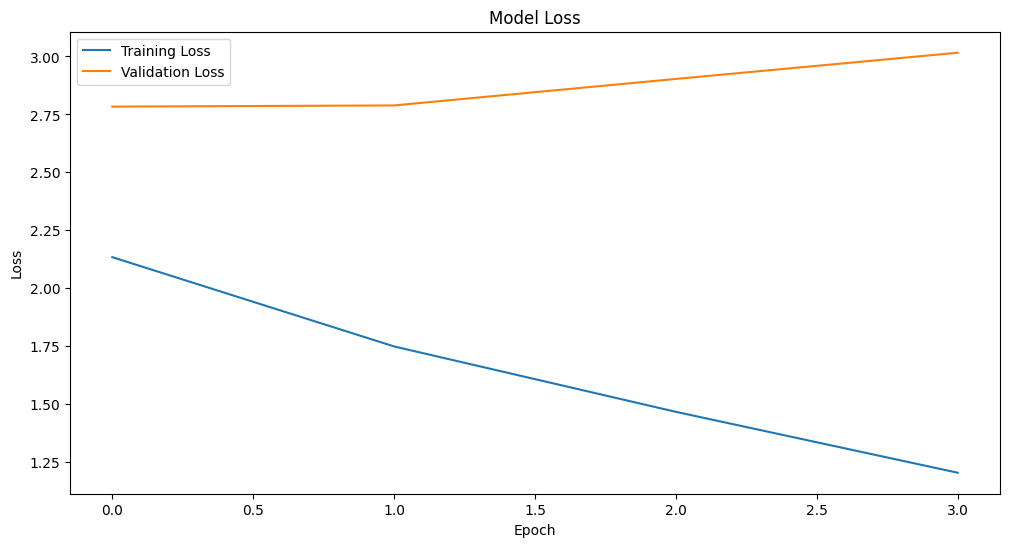

In [61]:
# Fit the model with manual validation split
history = model.fit(
    [user_ids_train, book_ids_train, X_train_selected], y_train,
    validation_data=([user_ids_test, book_ids_test, X_test_selected], y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, mse = model.evaluate([user_ids_test, book_ids_test, X_test_selected], y_test)
print("Mean Squared Error:", mse)

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
